In [20]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import os 
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

import importlib
from utils.afrr_preprocessing import preprocess_afrr_data
from lr_forecaster import run_lr_pipeline
#from gp_forecaster import run_gp_pipeline
from xgb_forecaster import run_xgb_pipeline

from utils.forecast_utils import get_forecast_params
from darts.timeseries import concatenate

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
data_path = "../data/afrr_price.parquet"
train_start = "2025-01-09 22:00:00"
test_start = "2025-03-03 22:00:00"
test_end = "2025-05-04 22:00:00"
target_col = "aFRR_UpCapPriceEUR"

In [22]:
forecast_params = get_forecast_params()
output_chunk_length = forecast_params['output_chunk_length']
forecast_horizon = forecast_params['forecast_horizon']
stride = forecast_params['stride']
quantiles = forecast_params['quantiles']

lr_models, lr_results = run_lr_pipeline(
    data_path=data_path,
    target_col=target_col,
    hyper_params_path= "../data/results/lr_aFRR_UpCapPriceEUR_hp_results.json",
    train_start=train_start,
    test_start=test_start,
    test_end=test_end,
    output_chunk_length=output_chunk_length,
    forecast_horizon=forecast_horizon,
    stride=stride)

#lr_results.to_parquet("lr_model_forecast.par")


----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 5064)
Complete dimension	: (120, 5064)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 120
Characteristic of projection	: 1.0


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

### XgBoost Model

In [23]:
forecast_params = get_forecast_params()
output_chunk_length = forecast_params['output_chunk_length']
forecast_horizon = forecast_params['forecast_horizon']
stride = forecast_params['stride']

xgb_model, xgb_results = run_xgb_pipeline(
    data_path=data_path,
    target_col=target_col,
    hyper_params_path="../data/results/xgb_hp_results.json",
    train_start=train_start,
    test_start=test_start,
    test_end=test_end,
    output_chunk_length=output_chunk_length,
    forecast_horizon=forecast_horizon,
    stride=stride)

#xgb_results.to_parquet("xgboost_model_forecast.par")

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 5064)
Complete dimension	: (120, 5064)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 120
Characteristic of projection	: 1.0


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

### Original Model

In [24]:
(afrr_pr_ts_scl_train, 
afrr_pr_ts_scl_test, 
afrr_pr_ts_orig_train, 
afrr_pr_ts_orig_test, 
exog_ts_scl_train, 
exog_ts_scl_test,
afrr_pr_scaler) = preprocess_afrr_data(data_path, train_start, test_start, test_end, val_start=None, use_validation=False, target_col=target_col)


----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 5064)
Complete dimension	: (120, 5064)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 120
Characteristic of projection	: 1.0


In [25]:
afrr_pr_ts_orig = concatenate([afrr_pr_ts_orig_train, afrr_pr_ts_orig_test], axis=0)
afrr_pr_ts_orig = afrr_pr_ts_orig.with_columns_renamed(['aFRR_UpCapPriceEUR'], col_names_new=["afrr_up_cap_price"])
result_df = lr_results.join([xgb_results, afrr_pr_ts_orig.to_dataframe()])

In [26]:
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
 
 
fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price', showlegend=True), hf_x=result_df.index, hf_y=result_df['afrr_up_cap_price'])
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price Linear Model', showlegend=True), hf_x=result_df.index, hf_y=result_df['lr_afrr_up_cap_price'])
#fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price Gaussian Process', showlegend=True), hf_x=result_df.index, hf_y=result_df['gp_afrr_up_cap_price_0.5'])
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price XGB Mean', showlegend=True), hf_x=result_df.index, hf_y=result_df['xgb_afrr_up_cap_price'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~3h</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': '0c20daa7-14a9-4837-b7e2-338638aec91a',
              'x': array([datetime.datetime(2025, 1, 13, 23, 0),
                          datetime.datetime(2025, 1, 14, 1, 0),
                          datetime.datetime(2025, 1, 14, 4, 0), ...,
                          datetime.datetime(2025, 5, 4, 16, 0),
                          datetime.datetime(2025, 5, 4, 19, 0),
                          datetime.datetime(2025, 5, 4, 22, 0)], dtype=object),
              'y': array([ 2.68,  2.68,  2.01, ..., 80.39, 75.5 , 40.11])},
             {'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~3h</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': '724a449f-aabc-403a-975f-d347e02b0df1',
              'x': array([datetime.datetime(

In [27]:
result_df = result_df.dropna()

In [28]:
import cvxpy as cp
import numpy as np

# 1. Clean data
y_true = result_df['afrr_up_cap_price'].values
y_pred = result_df[['lr_afrr_up_cap_price', 'xgb_afrr_up_cap_price']].values

y_true = (y_true - np.mean(y_true)) / np.std(y_true)
y_pred = (y_pred - np.mean(y_pred, axis=0)) / np.std(y_pred, axis=0)
weights = cp.Variable(2)
constraints = [cp.sum(weights) == 1, weights >= 0]
objective = cp.Minimize(cp.sum_squares(y_true - y_pred @ weights))
problem = cp.Problem(objective, constraints)

try:
    problem.solve()
except:
    print('failed')

# 5. Output
if 'optimal' in problem.status:
    optimal_weights = weights.value
    print("Optimal weights:", optimal_weights)
else:
    print("Solver failed. Status:", problem.status)

Optimal weights: [0.54081731 0.45918269]


In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

result_df['opt_afrr_up_cap_price'] = (
    optimal_weights[0] * result_df['lr_afrr_up_cap_price'] + 
    optimal_weights[1] * result_df['xgb_afrr_up_cap_price'] )

models = [
    'lr_afrr_up_cap_price',
    'xgb_afrr_up_cap_price',
    'opt_afrr_up_cap_price'
]

rmse_results = {}
y_true = result_df['afrr_up_cap_price']

for model in models:
    rmse = np.sqrt(mean_squared_error(y_true, result_df[model]))
    rmse_results[model] = rmse

print("Model RMSE Comparison:")
for model, rmse in sorted(rmse_results.items(), key=lambda x: x[1]):
    print(f"- {model:25s}: {rmse:.4f}")

best_single_rmse = max(rmse_results.values()) - rmse_results['opt_afrr_up_cap_price']
print(f"\nOptimized forecast improves by {best_single_rmse:.4f} RMSE over best single model")

Model RMSE Comparison:
- opt_afrr_up_cap_price    : 22.4613
- lr_afrr_up_cap_price     : 24.3867
- xgb_afrr_up_cap_price    : 25.3099

Optimized forecast improves by 2.8486 RMSE over best single model


In [30]:
result_df['cap_up_resid'] = (result_df['opt_afrr_up_cap_price'] - result_df['afrr_up_cap_price'])

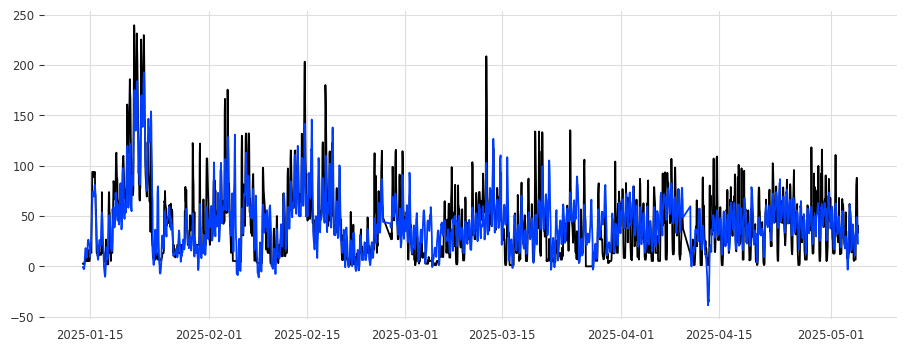

In [31]:
plt.plot(result_df["afrr_up_cap_price"])
plt.plot(result_df["opt_afrr_up_cap_price"])
plt.show()

In [32]:
result_df.to_parquet('/home/alqua/git/afrr-price-forecast-engine/data/results/afrr_price_forecast_UP.parquet')